# **Intel Image Classification - PyTorch Implementation**

Image Classification is one of the basic tasks that a CNN can do. 
Today we will be implementing the same on Intel Image Classification dataset, which contains  around 25k images of size 150x150 pixels, distributed under 6 categories of natural scenery around the world.



# **Imports**

Let's begin by importing the required dependencies.

In [1]:
#Imports
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
from PIL import Image
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import  DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

Kaggle notebooks is the most easiest ways to work on deep learning projects.
Data can be imported from the top-right corner dropdown menu, click 'Add Data' button.

The data is already seperated into Train dataset, Test dataset and Prediction dataset.
There are around 14k images in Train dataset, 3k images in Test dataset and 7k images in Prediction dataset.

There are 6 classes of data in each set, namely, buildings, forest, glacier, mountain, sea and street. 

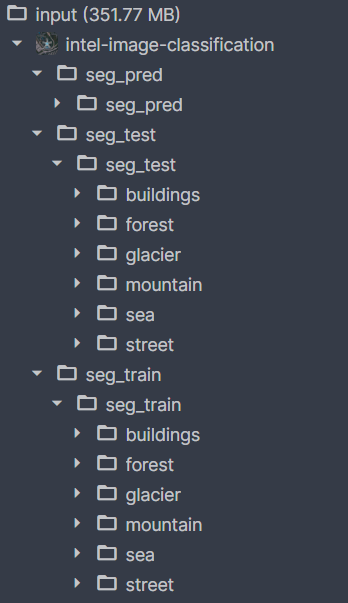

# Preparing the Data

In [2]:
#Defining respective directories:
DATA_DIR = '../input/intel-image-classification'

TRAIN_DIR = DATA_DIR + '/seg_train/seg_train'
VAL_DIR = DATA_DIR + '/seg_test/seg_test'

#classes in dataset:
classes = os.listdir(TRAIN_DIR)
classes

['street', 'forest', 'mountain', 'buildings', 'glacier', 'sea']

In [3]:
labels = {
    0: 'sea',
    1: 'forest',
    2: 'mountain',
    3: 'glacier',
    4: 'buildings',
    5: 'street',
}

Channel-wise data normalization: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

In [4]:
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.Resize((150,150)),
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize((150,150)),tt.ToTensor(), 
                         tt.Normalize(*stats)])

We'll use 'ImageFolder' to create PyTorch Datasets for training and validation.

In [5]:
train_ds = ImageFolder(TRAIN_DIR, train_tfms)
valid_ds = ImageFolder(VAL_DIR, valid_tfms)

Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 500 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an "out of memory" error.

Batch size is a term used in machine learning and deep learning that refers to the number of training examples utilized in one iteration.
For now, we'll initialize it to 64

In [6]:
batch_size = 64

The 'PyTorch DataLoader' automatically creates batches fromindividual fetched data samples for given batch size.

In [7]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Let's take a look at some sample images from the training dataloader.

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

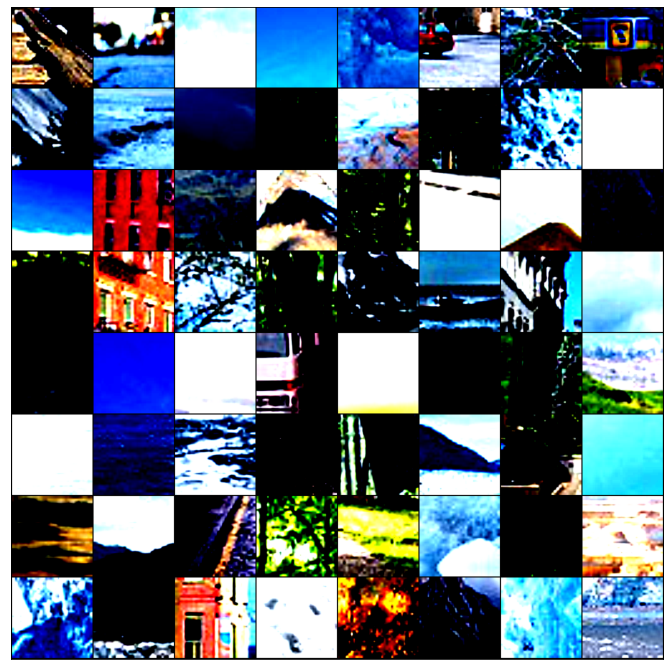

In [9]:
show_batch(train_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

# Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required. These are described in more detail in a previous tutorial.****

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (torch.device('cpu')) or a GPU (torch.device('cuda'))

In [11]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Base Model class 
Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the __init__ and __forward__ methods. We will later extend this class to try out different architectures. In fact, you can extend this model to solve any image classification problem.

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))



class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# Defining Model
We'll use ResNet34 as our CNN model. You can change this to your own liking. Check out torchvision models: https://pytorch.org/docs/stable/torchvision/models.html

In [15]:
resnet34 = models.resnet34()
resnet34

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We'll replace the last layer of the model to suit our dataset needs in '__init__'.
This can be stated as an example of transfer learning, as we are using pre-trained resnet34 network. 
The 'require_grad' if set True allows us to change the weights of the network.

In [25]:
class CNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 6)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

The tqdm allows to show progress bars, while our model is training

In [26]:
from tqdm.notebook import tqdm

Now we are ready to train our models.

# Training the Model
We'll now define couple of functions to train our model.
* Learning rate scheduling: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html
* Weight decay: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab
* Gradient clipping: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

Let's define a fit_one_cycle function to incorporate these changes. We'll also record the learning rate used for each batch.

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


Now let's move our model to our device.

In [28]:
model = to_device(CNN(), device)

Let's check the accuracy of our model before training.

In [29]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 7.027505397796631, 'val_acc': 0.0009765625}]

Let's freeze our model for initial training.

In [30]:
model.freeze()

AttributeError: 'VGG' object has no attribute 'fc'

Defining our hyperparameters.
We'll select Adam optimiser as it is known for delivering better results for classification problems.

In [31]:
epochs = 15
max_lr = 0.01
grad_clip = 0.5
weight_decay = 1e-4
opt_func = torch.optim.Adam

Starting training of our model.

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.00279, train_loss: 6.0106, val_loss: 6.0816, val_acc: 0.1423



Epoch [1], last_lr: 0.00759, train_loss: 6.0771, val_loss: 5.9180, val_acc: 0.1423


Now unfreeze the model and train some more.

In [23]:
model.unfreeze()

In [24]:
epochs = 10
max_lr = 0.01
grad_clip = 0.5
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [25]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.00279, train_loss: 1.4149, val_loss: 1.3662, val_acc: 0.6052



Epoch [1], last_lr: 0.00759, train_loss: 1.4406, val_loss: 1.5158, val_acc: 0.4214



Epoch [2], last_lr: 0.01000, train_loss: 1.4538, val_loss: 1.4557, val_acc: 0.5374



Epoch [3], last_lr: 0.00950, train_loss: 1.4578, val_loss: 1.5150, val_acc: 0.4708



Epoch [4], last_lr: 0.00812, train_loss: 1.4449, val_loss: 1.4439, val_acc: 0.4698



Epoch [5], last_lr: 0.00611, train_loss: 1.4386, val_loss: 1.3656, val_acc: 0.6104



Epoch [6], last_lr: 0.00389, train_loss: 1.4251, val_loss: 1.3578, val_acc: 0.6374



Epoch [7], last_lr: 0.00188, train_loss: 1.4128, val_loss: 1.3503, val_acc: 0.6021



Epoch [8], last_lr: 0.00050, train_loss: 1.3969, val_loss: 1.3359, val_acc: 0.6251



Epoch [9], last_lr: 0.00000, train_loss: 1.3898, val_loss: 1.3315, val_acc: 0.6326
CPU times: user 2min 29s, sys: 29.6 s, total: 2min 59s
Wall time: 7min 19s


Our model trained to over 60% accuracy in just 5 minutes! Try playing around with the data augmentations, network architecture & hyperparameters to achive the better results.

Let's plot the valdation set accuracies to study how the model improves over time.

In [26]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Accuracy vs. No. of epochs');

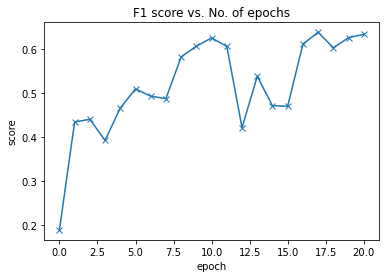

In [27]:
plot_scores(history)

We can also plot the training and validation losses to study the trend.

In [28]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

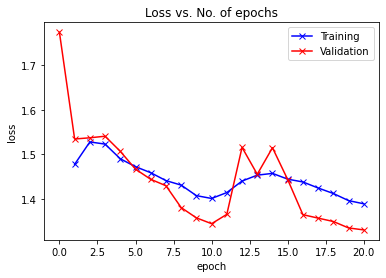

In [29]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [30]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

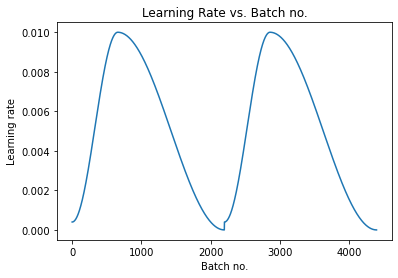

In [31]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.01, and then gradually decreases to a very small value.

# Predicting Unseen Data

In [32]:
PRED_DIR = '../input/intel-image-classification/seg_pred/seg_pred/'

Let's select ramdom image from prediction dataset.

In [33]:
import random

random_filename = random.choice([
    x for x in os.listdir(PRED_DIR)
    if os.path.isfile(os.path.join(PRED_DIR, x))
])

random_filename

'23934.jpg'

We'll apply the same transforms that we applied to training data earlier to this image.

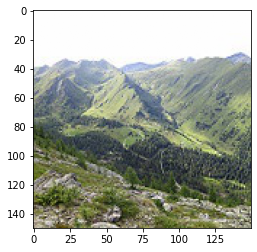

In [34]:
image = Image.open(PRED_DIR+random_filename)  
image = tt.ToTensor()(image)
plt.imshow(image.permute(1, 2, 0))
image = tt.Normalize(*stats,inplace=True)(image)

In [35]:
def predict_single(image):
    xb = image
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", decode_target(prediction, text_labels=True))
    plt.imshow(image.squeeze().permute(1, 2, 0))

In [36]:
def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

Prediction:  glacier(3)


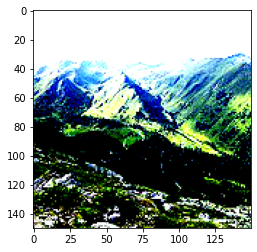

In [37]:
predict_single(image.unsqueeze(0))

In [38]:
torch.save(model.state_dict(), 'Intel-image-classifier-resnet50.pth')


# Save and Commit
Let's save the weights of the model, record the hyperparameters, and commit our experiment to Jovian. As you try different ideas, make sure to record every experiment so you can look back and analyze the results.+

In [39]:
!pip install jovian --upgrade --quiet

In [40]:
import jovian

<IPython.core.display.Javascript object>

In [41]:
jovian.reset()
jovian.log_hyperparams(arch='resnet34', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: 


Abort: 

In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   )

In [ ]:
project_name='IntelImageClassification'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['Intel-image-classifier-resnet50.pth.pth'])
